In [1]:
import sys
import os
import requests
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import models_mae
# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
# define the utils
 
imagenet_mean = np.array([0.4914, 0.4822, 0.4465])
imagenet_std = np.array([0.2470, 0.2435, 0.2616])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

c:\Users\syunt\.pyenv\pyenv-win\versions\3.11.6\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


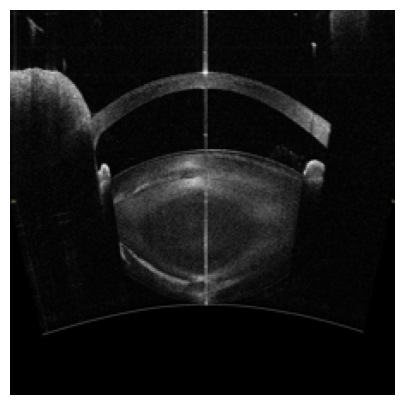

In [2]:
# load an image
img_url = '../../medicaldata/images/CASIA2_16/4403973_L_007.jpg'

img = Image.open(img_url).convert('RGB')
img = img.resize((224, 224))
img = np.array(img) / 255.
assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

<All keys matched successfully>


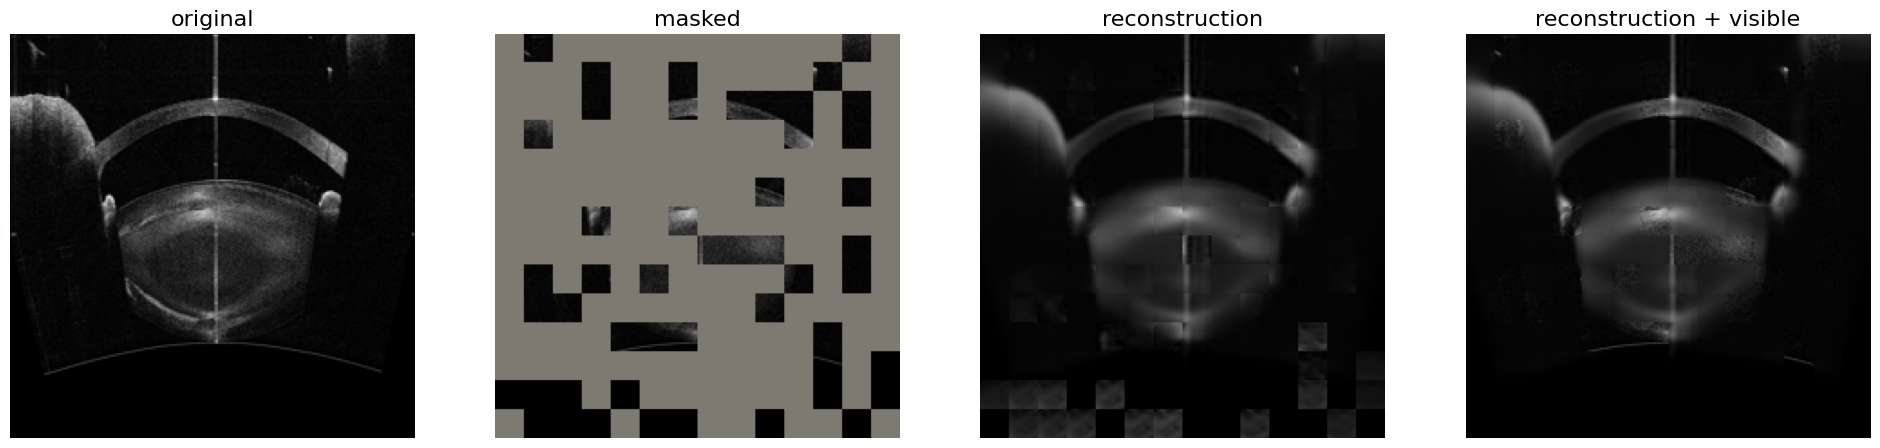

Model loaded.


In [5]:
chkpt_dir = '../model/MAE_400ep.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

run_one_image(img,model_mae)

#MAEモデルのパスを記述 > prepare_modelをutilに登録 > model_maeをprepare_modelで読み出し > mask_ratioを0にする.

print('Model loaded.')

In [55]:
import timm
#ここはtransformで代用できていそう つまり、データローダーのループの中だったら描く必要がない.

x = torch.tensor(img)

# make it a batch-like
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x)

model_mae.forward_encoder(x.float(),0)[0]

class VisionTransformer(timm.models.vision_transformer.VisionTransformer):
    """Vision Transformer with support for global average pooling"""

    def __init__(self,encoder,mask_ratio=0,global_pool=False, **kwargs):
        super(VisionTransformer, self).__init__(**kwargs)
        self.encoder = encoder
        self.mask_ratio = mask_ratio

        self.global_pool = global_pool
        if self.global_pool:
            norm_layer = kwargs["norm_layer"]
            embed_dim = kwargs["embed_dim"]
            self.fc_norm = norm_layer(embed_dim)

            del self.norm  # remove the original norm

    def forward_features(self, x):
        B = x.shape[0]

        #パッチをエンべディング
        x = self.patch_embed(x)

        #クラストークンを追加・ポジション円べディングも追加
        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)


        #トランスフォーマーブロックを適用
        for blk in self.blocks:
            x = blk(x)

        #normalization > outcomeにする過程で前結合そうを通すかどうか？
        if self.global_pool:
            x = x[:, 1:, :].mean(dim=1)  # global pool without cls token
            outcome = self.fc_norm(x)
        else:
            x = self.norm(x)
            outcome = x[:, 0]

        return outcome
    
    def forward(self,x):
        x = self.encoder(x,self.mask_ratio)[0][:, 0]
        x = self.forward_head(x)
        return x

In [34]:
model_mae.forward_encoder(x.float(),0)[0]

tensor([[[ 0.0918, -1.7006,  0.0862,  ...,  0.0512, -0.4785, -0.1471],
         [ 0.2074, -0.8115,  0.6715,  ...,  0.0359, -0.1142,  0.0772],
         [ 0.3381, -1.3054, -1.1896,  ...,  0.8418,  0.0036, -0.7977],
         ...,
         [ 0.3457, -0.5900, -0.2193,  ..., -0.1977,  0.2712, -0.1754],
         [ 0.3395, -0.3460, -1.4590,  ...,  1.1172, -0.2034,  0.1963],
         [ 0.2642, -0.7492, -1.0110,  ..., -0.1428,  0.2663, -0.7253]]],
       grad_fn=<NativeLayerNormBackward0>)

In [50]:
from functools import partial
import torch
import torch.nn as nn
import timm.models.vision_transformer

def vit_large_patch16(encoder,**kwargs):
    model = VisionTransformer(
        encoder,
        patch_size=16,
        embed_dim=1024,
        depth=24,
        num_heads=16,
        mlp_ratio=4,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        **kwargs
    )
    return model

vit = vit_large_patch16(model_mae.forward_encoder)

x = torch.tensor(img)

# make it a batch-like
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x)

#vit(x.float())
vit.forward_features(x.float()).size()

torch.Size([1, 1024])

In [54]:
model_mae.forward_encoder(x.float(),0)[0][:, 0].size()

torch.Size([1, 1024])

In [56]:
vit(x.float())

tensor([[[-1.2002,  0.9574,  1.0993,  ...,  0.3865,  0.0145,  0.0260],
         [-1.2800,  0.3349,  1.3296,  ...,  0.5023,  0.1882, -0.3424],
         [-1.1145,  0.0623,  1.3936,  ...,  0.3784, -0.0040,  0.3152],
         ...,
         [-0.9577,  0.6530,  1.0855,  ...,  0.4451,  0.1611,  0.1285],
         [-1.0622,  0.8515,  0.8173,  ...,  0.6102, -0.5498, -0.3122],
         [-1.1749,  0.4184,  1.0835,  ...,  0.0773, -0.7359,  0.4234]]],
       grad_fn=<ViewBackward0>)

In [ ]:
def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

MAE with pixel reconstruction:


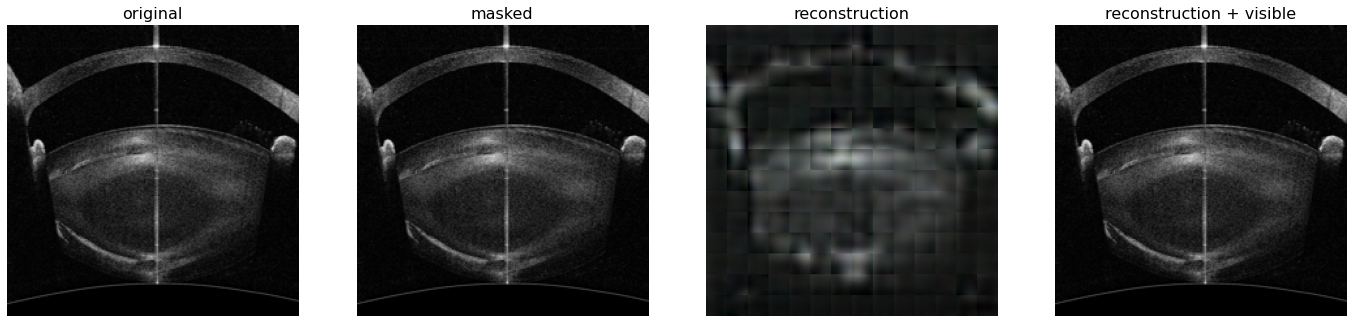

In [13]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)